---
layout:     post
title:      "Dollars to doughnuts"
subtitle: "analyzing my food spending"
date:       2017-04-06 12:00:00
author:     Andrew
header-img: img/posts/sympy_dynamics/balance_rock.jpg
header-credit: https://unsplash.com/@nbmat
tags:       programming dynamics sympy python
---

This is a quick post to share something that I was planning on doing otherwise, but thought others might find it interesting at best and slightly amusing at worst.

Everyone's always looking to find a place to save a few dimes, and over the past few months I've really started to take notice of my food spending.  After examining the last few months worth of budgets (I use mint to track my expenses and categorize them), I decided to make a concerted effort to eat out less, cook more and bring my lunch to work to reduce spending.

The big question is, did it work?  I'm not performing a rigorous statistical analysis here, but thought I'd at least take a look and see if I can see anything.

Fine print:
* I was on vacation in the beginning of January, using cash only, so those transactions won't appear
* I've been conciously reducing spending for the past 3-4 works
* I didn't remove anomolies, like covering a meal for a group and getting paid in cash
* Some restaurants show up in Alcohol & Bars

I'm going to be using my programming language of choice, python for this task.

In [85]:
import csv
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from collections import namedtuple
from datetime import datetime, timedelta, date
from itertools import groupby, dropwhile, accumulate
from decimal import Decimal, getcontext
from pprint import pprint

%matplotlib inline

getcontext().prec = 6
preview_size = 5

mpl.rcParams['figure.figsize'] = (12.0, 10.0)
mpl.rcParams['font.size'] = 15

First, I downloaded all my transactions from mint in a .csv file.  I opened the csv and removed everything except the 3 columns for date, amount and category (I could have done some of that in python, but it was just easier to do it ahead of time)

Then I open the file and read in all of the rows.  This will bring the rows in as lists, so the data is already separated by column.

In [2]:
with open('transactions.csv','r') as transactions_csv:
    transactions = list(csv.reader(transactions_csv, delimiter=','))
    

pprint(transactions[:preview_size])

[['Date', 'Amount', 'Category'],
 ['4/06/2017', '1.34', 'Lunch at Work'],
 ['4/06/2017', '2.55', 'Lunch at Work'],
 ['4/05/2017', '7.22', 'Restaurants'],
 ['4/05/2017', '10.25', 'Movies & DVDs']]


The first step is to make the data a bit more usable, starting with removing the column header text. `[1:]`  means to take everything except the first item in `transactions` (python indexing starts at `0`)

In [3]:
transactions = transactions[1:]

Right now, all the data is being stored as strings, which makes it difficult to do any kind of sorting or math.  A `tuple` is a sequence of items, so I'm creating a tuple that has three named attributes, `date`, `amnt`, and `cat`.  This means we can access the data by name instead of index.

`datetime.strptime` turns a string into an actual date object in python, and I'll be storing the amount as a `Decimal`.  Category remains a string

As an aside, here's a fun example of what can happen if you store currencies as floating point numbers: https://hackerone.com/reports/176461

In [4]:
T = namedtuple('T','date, amount, category')

transactions = [T(datetime.strptime(date,"%m/%d/%Y"),
                  Decimal(amount),
                  category) for date,amount,category in transactions]

Our transaction list still contains every transaction from 2017 though, so we'll need to filter out the non-food related one.  Here is the list of the food categories that I track in mint.

In [5]:
food_categories = ['Alcohol & Bars',
'Coffee Shops',
'Fast Food',
'Groceries',
'Restaurants',
'Lunch at Work',
'Snacks']

transactions = [trans for trans in transactions if trans.category in food_categories]

Lastly, let's make sure the data is sorted (this is important later when we want to group the data).  This will sort the transactions first by date, then by category for transactions that happen on the same date.

In [6]:
transactions.sort(key = lambda trans: (trans.date, trans.category))

Next, let's trim our date range down to something recent.  I'll go from last October through today.

In [16]:
transactions = list(dropwhile(lambda trans: trans.date < datetime(day=1, month=10, year=2016), transactions))

Now our data looks something like this:

In [17]:
pprint(transactions[:preview_size])

[T(date=datetime.datetime(2016, 10, 1, 0, 0), amount=Decimal('35.16'), category='Alcohol & Bars'),
 T(date=datetime.datetime(2016, 10, 1, 0, 0), amount=Decimal('9.92'), category='Alcohol & Bars'),
 T(date=datetime.datetime(2016, 10, 1, 0, 0), amount=Decimal('2.12'), category='Fast Food'),
 T(date=datetime.datetime(2016, 10, 1, 0, 0), amount=Decimal('16.7'), category='Groceries'),
 T(date=datetime.datetime(2016, 10, 1, 0, 0), amount=Decimal('6.2'), category='Lunch at Work')]


First, let's look at a simple bar graph of spending.  First, let's group the transactions so we can sum all the transactions that happened on the same day. `groupby` does this by traversing the list and grouping items by date as it finds them.  This is why it's important that our data was sorted, otherwise the groupings could be messed up.

In [18]:
grouped_transactions = groupby(transactions, key = lambda trans: trans.date)

Now a list of dates is made, and for each of those dates, all the transactions are summed up.

In [19]:
dates = []
daily_sums = []

for date, transaction_group in grouped_transactions:
    dates.append(date)
    daily_sums.append(sum([trans.amount for trans in transaction_group]))

All that's left to do now is plot the data (most of this code is just to make it look nice)

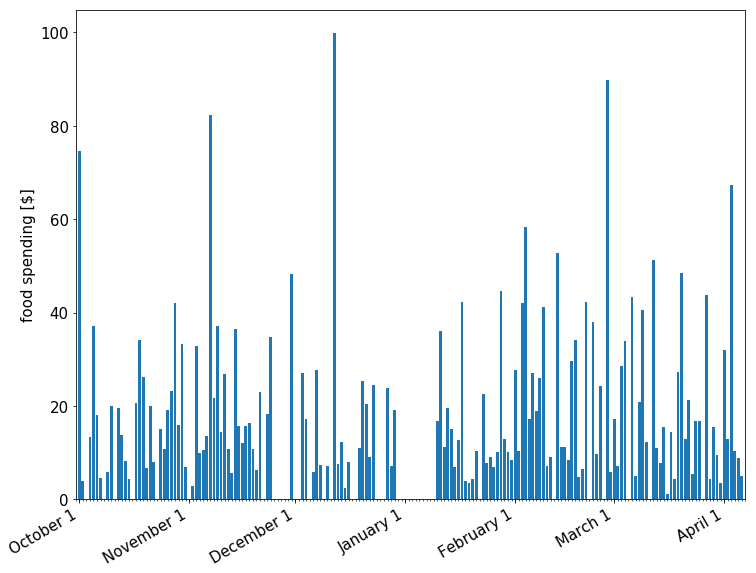

In [23]:
days = mdates.DayLocator()
months = mdates.MonthLocator()
years = mdates.YearLocator()
monthFmt = mdates.DateFormatter('%B %-d')

fig, ax = plt.subplots(1)
plt.ylabel("food spending [$]")
fig.autofmt_xdate()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthFmt)
ax.xaxis.set_minor_locator(days)
ax.set_xlim([dates[0]-timedelta(days=1),dates[-1]+timedelta(days=1)])

ax.bar(dates, daily_sums)
plt.show()

The data looks plausible, but it's not particularly revealing.  With this fine of detail, it's hard to see any clear trends.  Let's try a [moving average](https://en.wikipedia.org/wiki/Moving_average) to see if that reveals any trends.

In this case, I'll be using a moving average to average my spending over the last `n` days.  So what that means for these plots is the numbers represent my average spending for the previous `n` days.

For the overall spending, let's see what a 15 day moving average looks like.

In [27]:
n = 30

# index will be the date that we'll use to loop through our data
# it starts n days from the beginning, which the first day that we
# have enough data to average
start = dates[0]
end = dates[-1]
index = start + timedelta(days = n-1)

rolling = []
rolling_dates = []

while index <= end:
    
    # on each loop, filter out any transactions that don't fall in our window
    rolled_transactions = filter(lambda trans: start <= trans.date <= index, transactions)
    
    # add that average to our result list
    rolling.append(sum([trans.amount for trans in rolled_transactions])/n)
    
    # we're also keeping track of the dates for plotting later
    rolling_dates.append(index)
    
    index = index + timedelta(days = 1)
    start = start + timedelta(days = 1)    

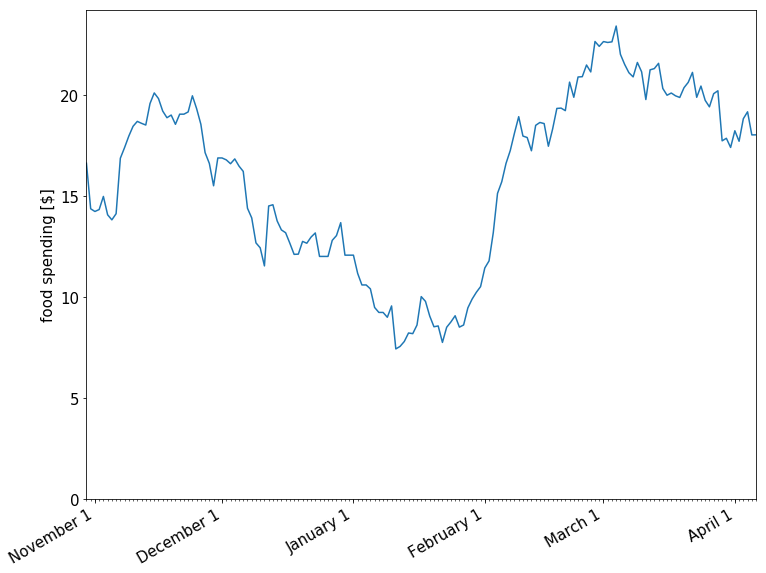

In [28]:
fig, ax = plt.subplots(1)
ax.plot(rolling_dates,rolling)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthFmt)
ax.xaxis.set_minor_locator(days)
fig.autofmt_xdate()
plt.ylabel("food spending [$]")
ax.set_xlim([rolling_dates[0],rolling_dates[-1]])
ax.set_ylim(0)
plt.show()

Nothing absolutely definitive, but it does look like my effort to re-reign in my spending on food is having an effect.  From this, it's clear how Jan. and Feb. had relatively high spending compared to late last year.

However, I'm also interested in whether my intentions to get take-out and eat lunch at work less have panned out as well.  To see about this, let's take a look at a stacked bar chart.  This will show the breakdown of spending by category.  Again, with a 30 day moving average.

In [30]:
n = 30

start = dates[0]
end = dates[-1]
index = start + timedelta(days = n)

rolling = []
rolling_dates = []

while index <= end:
    
    rolled_transactions = filter(lambda trans: start <= trans.date <= index, transactions)
    rolled_transactions = sorted(list(rolled_transactions), key = lambda trans: trans.category)
    
    stack = {}
    for cat,cat_trans in groupby(rolled_transactions, lambda trans: trans.category):
        stack[cat] = sum([trans.amount for trans in cat_trans])/n
        
    rolling.append([float(stack[cat]) if cat in stack else float(0) for cat in food_categories])
    rolling_dates.append(index)
    
    index = index + timedelta(days = 1)
    start = start + timedelta(days = 1)    

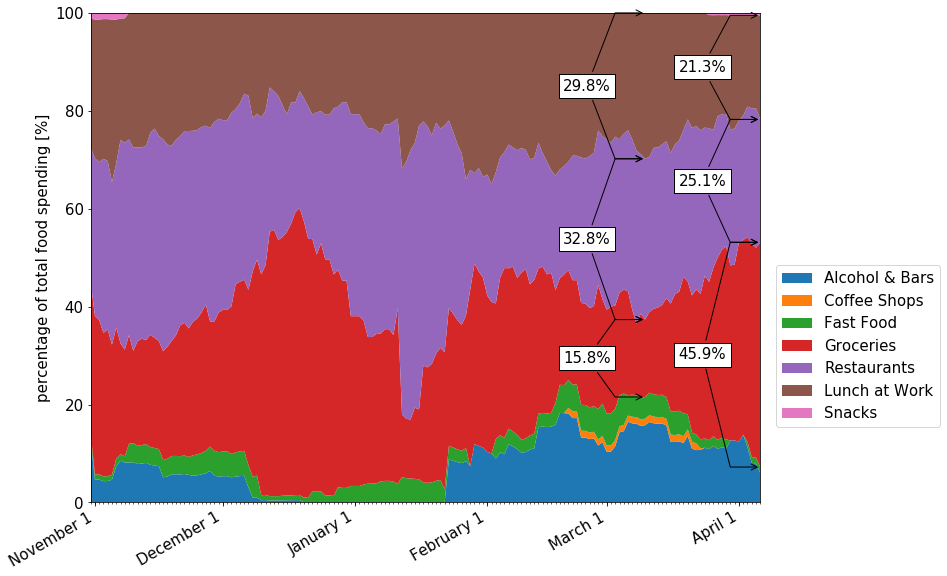

In [201]:
def add_braces(ax, text, x0, y0, x1, y1, y2):
    ax.annotate(text,
                xy=(x1,y2),
                xytext=(x0,y0),
                xycoords='data',
                ha='right',
                va='center',
                bbox=dict(boxstyle='square', fc='white'),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc, armB=-30"))
    ax.annotate(text, 
                xy=(x1,y1),
                xytext=(x0,y0),
                xycoords='data',
                ha='right',
                va='center',
                bbox=dict(boxstyle='square', fc='white'),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc, armB=-30"))

y = np.row_stack(list(zip(*rolling)))  
percent = y /  y.sum(axis=0).astype(float) * 100 

fig, ax = plt.subplots(1, facecolor='white')
ax.stackplot(rolling_dates, percent)
ax.legend(food_categories,bbox_to_anchor=(1.28, .5))
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthFmt)
ax.xaxis.set_minor_locator(days)
fig.autofmt_xdate()
plt.ylabel("percentage of total food spending [%]")
ax.set_xlim([rolling_dates[0],rolling_dates[-1]])
ax.set_ylim([0,100])

date_1 = datetime(day=10, month=3, year=2017)
date_1_index = rolling_dates.index(date_1)

accu = list(accumulate([percent[i][date_1_index] for i in range(7)]))

for i in [2,3,4]:
    add_braces(ax,"{0:.1f}%".format(accu[i+1]-accu[i]),(date_1 - timedelta(days = 8)),(accu[i+1]-accu[i])/2 + accu[i],date_1,accu[i],accu[i+1])


date_2 = rolling_dates[-1]
date_2_index = rolling_dates.index(date_2)

accu = list(accumulate([percent[i][date_2_index] for i in range(7)]))

for i in [2,3,4]:
    add_braces(ax,"{0:.1f}%".format(accu[i+1]-accu[i]),(date_2 - timedelta(days = 8)),(accu[i+1]-accu[i])/2 + accu[i],date_2,accu[i],accu[i+1])

    
plt.show()

62

In [88]:
march_1_index = rolling_dates.index(datetime(day=1, month=3, year=2017))

food_categories = ['Alcohol & Bars',
'Coffee Shops',
'Fast Food',
'Groceries',
'Restaurants',
'Lunch at Work',
'Snacks']


accu

[10.339432975582287,
 11.620631334125562,
 18.172996975085404,
 39.383748054888741,
 74.168809374291698,
 100.0,
 100.0]

In [71]:
len(rolling_dates)

158